In [1]:
from rostering_solver import Instance, Solver
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
city = 'berlin'
demand_baseline = "1.00"
demand_type = "doublepeak" # "fixed" demand_type
outsourcing_cost_multiplier = 1.5
model = "flex" # "fixed" # "flex"

read_instance_file = False

In [3]:
if read_instance_file:
    demand_file = f'{city}_db={demand_baseline}_dt={demand_type}.csv'
    print(demand_file)

    demand_df = pd.read_csv(demand_file, index_col=0)
    demand_df['area_id'] = demand_df['area_id'].astype(str) 
    days_ = []
    for i in range(7):
        days_.append([i, "1.00", "uniform"])
    days = pd.DataFrame(days_, columns=['day', 'demand_baseline', 'demand_type']) 
else:
    # Generate instance file
    # Generate several days instances 
    days = pd.DataFrame([
        [0, demand_baseline, demand_type], # Monday
        [1, demand_baseline, demand_type], # Tuesday
        [2, demand_baseline, demand_type], # Wednesday
        [3, demand_baseline, demand_type], # Thursday
        [4, demand_baseline, demand_type], # Friday
        [5, demand_baseline, demand_type], # Satuday
        [6, demand_baseline, demand_type], # Sunday
    ], columns=['day', 'demand_baseline', 'demand_type']
    )

    demand = []
    area_region_map = None

    for i, row in days.iterrows():
        demand_baseline, demand_type = row['demand_baseline'], row['demand_type']
        key = f'{city}_db={demand_baseline}_dt={demand_type}'

        instance_file = f'../instances/{city}_db={demand_baseline}_dt={demand_type}.json'
        with open(instance_file, 'r') as file:
            instance_data = json.load(file)

        if area_region_map is None:
            regions = instance_data['geography']['city']['regions']
            area_region_map = {}
            for region in regions:
                areas = region['areas'] 
                for area in areas:
                    area_region_map[area['id']] = region['id']
        
        scenario = random.randint(0, instance_data['num_scenarios']-1)
        data_ = (
            pd.DataFrame(instance_data['scenarios'][scenario]['data'])
            .assign(
                day = row['day']
            )
        )
        demand.append(data_)

    demand_df = pd.concat(demand)
    # Add region
    demand_df['region_id'] = demand_df['area_id'].map(area_region_map)

    demand_df = demand_df[['day', 'region_id', 'area_id', 'demand', 'required_couriers']]
    #demand_df.to_csv(f'{city}_db={demand_baseline}_dt={demand_type}.csv')

display(demand_df.head(10))

,day,region_id,area_id,demand,required_couriers
0,0,1,10115,"[0, 2, 3, 4, 3, 3, 1, 0]","[0, 1, 1, 1, 1, 1, 1, 0]"
1,0,1,10117,"[1, 1, 3, 2, 2, 2, 1, 0]","[1, 1, 1, 1, 1, 1, 1, 0]"
2,0,1,10119,"[0, 2, 2, 2, 1, 3, 2, 0]","[0, 1, 1, 1, 1, 1, 1, 0]"
3,0,1,10178,"[0, 3, 2, 1, 2, 4, 0, 0]","[0, 1, 1, 1, 1, 1, 0, 0]"
4,0,1,10179,"[1, 3, 3, 3, 3, 2, 5, 0]","[1, 1, 1, 1, 1, 1, 1, 0]"
5,0,2,10243,"[0, 2, 7, 5, 5, 8, 3, 0]","[0, 1, 2, 1, 1, 2, 1, 0]"
6,0,0,10245,"[0, 0, 6, 4, 4, 2, 4, 0]","[0, 0, 2, 1, 1, 1, 1, 0]"
7,0,0,10247,"[0, 4, 5, 4, 4, 8, 1, 0]","[0, 1, 1, 1, 1, 2, 1, 0]"
8,0,0,10249,"[0, 2, 5, 6, 4, 7, 2, 0]","[0, 1, 1, 2, 1, 2, 1, 0]"
9,0,0,10315,"[0, 1, 8, 5, 2, 6, 1, 1]","[0, 1, 2, 1, 1, 2, 1, 1]"


In [4]:
# READ SHIFTS
key = f'{city}_db={demand_baseline}_dt={demand_type}'

shifts_file = f'../shifts/{city}_db={demand_baseline}_dt={demand_type}.json'
with open(shifts_file, 'r') as file:
    shifts_data = json.load(file)

shifts_df = (
    pd.DataFrame(shifts_data).query(f'outsourcing_cost_multiplier == {outsourcing_cost_multiplier} & demand_type == "{demand_type}" & model == "{model}"')
    .query('regional_multiplier == 1.5 & global_multiplier == 0.8')
)

shifts_df.head(10)


,instance_file,city,demand_baseline,demand_type,model,max_n_shifts,outsourcing_cost_multiplier,regional_multiplier,global_multiplier,region,shifts_start,shifts_end
744,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,0,"{'0': 0, '1': 2}","{'0': 4, '1': 6}"
745,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,1,"{'0': 0, '1': 2, '2': 4}","{'0': 4, '1': 6, '2': 8}"
746,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,2,"{'0': 0, '1': 2}","{'0': 4, '1': 6}"
747,berlin_db=1.00_dt=doublepeak.json,berlin,1.0,doublepeak,flex,NaN,1.5,1.5,0.8,3,"{'0': 0, '1': 2, '2': 4}","{'0': 4, '1': 6, '2': 8}"


In [5]:
# INPUT DATA
regions = [0]

period_demands = demand_df.set_index(['area_id', 'day'])['demand'].to_dict()
period_couriers = demand_df.set_index(['area_id', 'day'])['required_couriers'].to_dict()

region_area_map = { k: list(v) for k, v in demand_df.groupby('region_id').agg({'area_id': 'unique'}).to_dict()['area_id'].items()}
area_map = {a: i for i, a in enumerate(list(demand_df['area_id'].unique())) }
areas = list(demand_df['area_id'].unique())

shifts_start = shifts_df.set_index('region')['shifts_start'].to_dict()
shifts_end = shifts_df.set_index('region')['shifts_end'].to_dict()

print(shifts_start)
print(shifts_end)

{0: {'0': 0, '1': 2}, 1: {'0': 0, '1': 2, '2': 4}, 2: {'0': 0, '1': 2}, 3: {'0': 0, '1': 2, '2': 4}}
{0: {'0': 4, '1': 6}, 1: {'0': 4, '1': 6, '2': 8}, 2: {'0': 4, '1': 6}, 3: {'0': 4, '1': 6, '2': 8}}


In [6]:
# VALIDATION OF START
r = 0
Theta = [i for i in range(8)]

print('START')
shifts_ = shifts_start[r]
for shift, start in shifts_.items():
    print(shift, ':', start)
    for theta in Theta[:start]:
        print(' ', theta, 'cannot work!')

# VALIDATION OF END
print('END')
shifts_ = shifts_end[r]
for shift, end in shifts_.items():
    print(shift, ':', end)
    for theta in Theta[end+1:]:
        print(' ', theta, 'cannot work!')

START
0 : 0
1 : 2
  0 cannot work!
  1 cannot work!
END
0 : 4
  5 cannot work!
  6 cannot work!
  7 cannot work!
1 : 6
  7 cannot work!


In [7]:
# MODEL 
region = 0
regions = [region]
region_employees = {region:10}

i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve()
s.summary_results()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-12
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1320 rows, 36504 columns and 16900 nonzeros
Model fingerprint: 0x76c41707
Model has 4200 quadratic constraints
Variable types: 3304 continuous, 33200 integer (33200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 269 rows and 31813 columns
Presolve time: 0.09s
Presolved: 1051 rows, 4691 columns, 13501 nonzeros
Variable types: 0 continuous, 4691 integer (4604 binary)
Found heuristic solution: objective 2254.5000000

Root relaxation: objective 1.110000e+03, 2101 iterations, 0.03 seconds (0.03 work units)

    N

{'regions': [0],
 'n_employees': 10,
 'obj_value': 1128.0,
 'elapsed_time': 1.6462750434875488,
 'status': 2,
 'hiring_costs': 240.0,
 'outsourcing_costs': 888.0,
 'exec_time': 1.6572110652923584,
 'n_variables': 36504,
 'n_constraints': 1320,
 'n_nonzeroes': 16900}

# Analysis

In [8]:
# Utilization rate
util_rate = sum([s.k_var[e, a, theta, d].X for r in s.R for e in s.E[r] for a in s.A[r] for theta in s.Theta for d in s.D]) / \
    sum([s.r_var[e, p, d].X * s.h[p] / 2 for e in s.employees for p in s.shifts for d in s.D])
print(util_rate)

1.0


In [9]:
# Parcels outsourced
region = 0
selected_areas = s.i.region_area_map[region]

outsourced = sum([1 for a in s.i.areas for theta in s.Theta for d in s.D if s.omega_var[s.i.area_map[a], theta, d].X > 0.5]) 
parcels_with_demand = sum([1 for a in s.i.areas for theta in s.Theta for d in s.D if s.couriers_needed[s.i.area_map[a], theta, d] > 0 and a in selected_areas ])

pct_outsourced = outsourced / parcels_with_demand * 100
print(pct_outsourced)

57.74647887323944


# Optimal result

In [10]:
results = []
region_employees = {}

# Iterate over regions and employees
for reg in [0, 1, 2, 3]:
    print(f'Region: {reg}')
    regions = [reg]
    for n_employees in tqdm([10, 15, 17, 20, 25, 30, 60]):
        region_employees[region] = n_employees
        i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end)

        s = Solver(i)
        s.solve()
        print('-----', n_employees, s.summary_results()['obj_value'])
        results.append(s.summary_results())
    break

Region: 0


  0%|          | 0/7 [00:00<?, ?it/s]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1320 rows, 36504 columns and 16900 nonzeros
Model fingerprint: 0x76c41707
Model has 4200 quadratic constraints
Variable types: 3304 continuous, 33200 integer (33200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 269 rows and 31813 columns
Presolve time: 0.08s
Presolved: 1051 rows, 4691 columns, 13501 nonzeros
Variable types: 0 continuous, 4691 integer (4604 binary)
Found heuristic solution: objective 2254.5000000

Root relaxation: objective 1.110000e+03, 2101 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

 14%|█▍        | 1/7 [00:01<00:11,  1.97s/it]

----- 10 1128.0
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1700 rows, 53104 columns and 25070 nonzeros
Model fingerprint: 0xc71e4213
Model has 6300 quadratic constraints
Variable types: 3304 continuous, 49800 integer (49800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 329 rows and 46273 columns
Presolve time: 0.12s
Presolved: 1371 rows, 6831 columns, 20046 nonzeros
Variable types: 0 continuous, 6831 integer (6744 binary)
Found heuristic solution: objective 2378.2500000

Root relaxation: objective 7.209000e+02, 3280 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

 29%|██▊       | 2/7 [02:02<05:58, 71.79s/it]

----- 15 778.5
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1852 rows, 59744 columns and 28338 nonzeros
Model fingerprint: 0xccf5df29
Model has 7140 quadratic constraints
Variable types: 3304 continuous, 56440 integer (56440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 353 rows and 52057 columns
Presolve time: 0.16s
Presolved: 1499 rows, 7687 columns, 22664 nonzeros
Variable types: 0 continuous, 7687 integer (7600 binary)
Found heuristic solution: objective 2406.7500000

Root relaxation: objective 6.165000e+02, 3136 iterations, 0.08 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

 43%|████▎     | 3/7 [03:09<04:37, 69.49s/it]

----- 17 676.5
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2080 rows, 69704 columns and 33240 nonzeros
Model fingerprint: 0x9d0fcb6b
Model has 8400 quadratic constraints
Variable types: 3304 continuous, 66400 integer (66400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 389 rows and 60733 columns
Presolve time: 0.24s
Presolved: 1691 rows, 8971 columns, 26591 nonzeros
Variable types: 0 continuous, 8971 integer (8884 binary)
Found heuristic solution: objective 2472.7500000

Root relaxation: objective 5.385000e+02, 3439 iterations, 0.13 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

 57%|█████▋    | 4/7 [03:39<02:41, 53.85s/it]

----- 20 619.5
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2460 rows, 86304 columns and 41410 nonzeros
Model fingerprint: 0x5d076355
Model has 10500 quadratic constraints
Variable types: 3304 continuous, 83000 integer (83000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 449 rows and 75193 columns
Presolve time: 0.19s
Presolved: 2011 rows, 11111 columns, 33136 nonzeros
Variable types: 0 continuous, 11111 integer (11024 binary)
Found heuristic solution: objective 2583.0000000

Root relaxation: objective 6.270000e+02, 3362 iterations, 0.10 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

 71%|███████▏  | 5/7 [04:09<01:30, 45.34s/it]

----- 25 649.5
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2840 rows, 102904 columns and 49580 nonzeros
Model fingerprint: 0xe2dd04ef
Model has 12600 quadratic constraints
Variable types: 3304 continuous, 99600 integer (99600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 509 rows and 89653 columns
Presolve time: 0.24s
Presolved: 2331 rows, 13251 columns, 39681 nonzeros
Variable types: 0 continuous, 13251 integer (13164 binary)
Found heuristic solution: objective 2718.7500000

Root relaxation: objective 7.470000e+02, 3502 iterations, 0.06 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Ex

 86%|████████▌ | 6/7 [04:11<00:30, 30.68s/it]

----- 30 747.0
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5120 rows, 202504 columns and 98600 nonzeros
Model fingerprint: 0x9975a6c1
Model has 25200 quadratic constraints
Variable types: 3304 continuous, 199200 integer (199200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 869 rows and 176413 columns
Presolve time: 0.53s
Presolved: 4251 rows, 26091 columns, 78951 nonzeros
Variable types: 0 continuous, 26091 integer (26004 binary)
Found heuristic solution: objective 3446.2500000

Root relaxation: objective 1.467000e+03, 3884 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work


100%|██████████| 7/7 [04:14<00:00, 36.40s/it]


In [11]:
results_df = pd.DataFrame(results)
results_df = (
    results_df 
    .assign(
        obj_value = results_df['obj_value'].apply(lambda x: np.round(x, 1)),
        region = results_df['regions'].apply(lambda x: x[0])
    )
)
results_df

,regions,n_employees,obj_value,elapsed_time,status,hiring_costs,outsourcing_costs,exec_time,n_variables,n_constraints,n_nonzeroes,region
0,[0],10,1128.0,1.592804,2,240.0,888.0,1.603006,36504,1320,16900,0
1,[0],15,778.5,120.070371,9,360.0,418.5,120.084543,53104,1700,25070,0
2,[0],17,676.5,65.998418,2,408.0,268.5,66.014769,59744,1852,28338,0
3,[0],20,619.5,29.095894,2,480.0,139.5,29.113679,69704,2080,33240,0
4,[0],25,649.5,29.241861,2,600.0,49.5,29.263726,86304,2460,41410,0
5,[0],30,747.0,1.039404,2,720.0,27.0,1.066631,102904,2840,49580,0
6,[0],60,1467.0,0.719940,2,1440.0,27.0,0.769862,202504,5120,98600,0


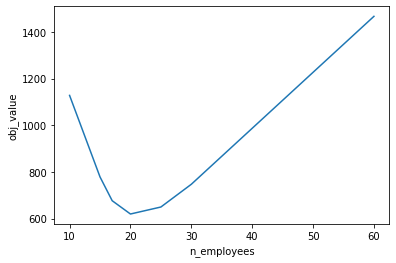

In [12]:
sns.lineplot(data=results_df.query('region == 0'), x='n_employees', y='obj_value')
plt.show()

In [13]:
# REGION RESULTS
region = 0
selected_areas = s.i.region_area_map[region]

region_results = results_df.query(f'region == {region}')

# OPTIMAL SOLUTION
optimal_n_employees = int(region_results.query(f'obj_value == {results_df["obj_value"].min()}')['n_employees'].values[0])
region_employees = {}
region_employees[region] = optimal_n_employees

i = Instance(regions=[region], areas=areas, 
    region_area_map=region_area_map, area_map=area_map, 
    period_demands=period_demands, period_couriers=period_couriers,
    region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
    shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2080 rows, 69704 columns and 33240 nonzeros
Model fingerprint: 0x9d0fcb6b
Model has 8400 quadratic constraints
Variable types: 3304 continuous, 66400 integer (66400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 389 rows and 60733 columns
Presolve time: 0.16s
Presolved: 1691 rows, 8971 columns, 26591 nonzeros
Variable types: 0 continuous, 8971 integer (8884 binary)
Found heuristic solution: objective 2472.7500000

Root relaxation: objective 5.385000e+02, 3439 iterations, 0.11 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

In [14]:
# Area Employee assignment (for each region)
area_employee_assignment = []
for e in s.employees:
    for a in areas:
        for theta in s.Theta:
            for d in s.D:
                for p in s.shifts:
                    shift = int(s.r_var[e, p, d].X)
                value = s.k_var[e, s.i.area_map[a], theta, d].X
                if value > 0.5:
                    area_employee_assignment.append([e, a, theta, d, shift])

area_employee_assignment_df = pd.DataFrame(area_employee_assignment, columns=['employee', 'area', 'period', 'day', 'shift'])

In [15]:
area_employee_assignment_df.query('employee == 0').sort_values(['day', 'period'])

,employee,area,period,day,shift
19,0,10365,1,0,0
6,0,10249,2,0,0
7,0,10249,3,0,0
21,0,10365,4,0,0
12,0,10315,3,1,1
4,0,10247,4,1,1
11,0,10249,5,1,1
2,0,10245,6,1,1
14,0,10318,0,3,0
20,0,10365,1,3,0


In [16]:
couriers_needed_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.couriers_needed[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'n_couriers'})
        .assign(day = d)
    )
    couriers_needed_.append(area_day_data)

couriers_needed_df = pd.concat(couriers_needed_)

# Demand
deliveries_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.deliveries[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'deliveries'})
        .assign(day = d)
    )
    deliveries_.append(area_day_data)

deliveries_df = pd.concat(deliveries_)

couriers_needed_df = pd.merge(couriers_needed_df, deliveries_df, on=['area', 'period', 'day'])
couriers_needed_df.head()

# areas
area_period_days_df = (
    area_employee_assignment_df
    .groupby(['area', 'period', 'day'])
    .agg({'employee': ['count', 'unique']})
    .reset_index()
)
area_period_days_df.columns = ['area', 'period', 'day', 'employee_count', 'employees_assign']
area_period_days_df

# Outsourcing
outsourcing_shifts = []
for a in areas:
    for theta in s.Theta:
        for d in s.D:
            value = s.omega_var[s.i.area_map[a],theta,d].X
            #print(f'{a} {theta} {d} : {value}')
            if value > 0.0:
                outsourcing_shifts.append([a, theta, d, value])

outsourcing_shifts_df = pd.DataFrame(outsourcing_shifts, columns=['area', 'period', 'day', 'cost_outsource'])

# Join all
whole_solution_df = (
    couriers_needed_df
    # Employees
    .merge(area_period_days_df,  on=['area', 'period', 'day'], how='left')
    # Outsource
    .merge(outsourcing_shifts_df, on=['area', 'period', 'day'], how='left')
)
# DROP AREAS NOT IN REGION!!
whole_solution_df = whole_solution_df.query(f'area.isin({selected_areas})')
whole_solution_df['employee_count'].fillna(0, inplace=True)

whole_solution_df.head(30)

,area,period,n_couriers,day,deliveries,employee_count,employees_assign,cost_outsource
6,10245,0,0.0,0,0.0,0.0,NaN,NaN
7,10247,0,0.0,0,0.0,0.0,NaN,NaN
8,10249,0,0.0,0,0.0,0.0,NaN,NaN
9,10315,0,0.0,0,0.0,0.0,NaN,NaN
10,10317,0,0.0,0,0.0,0.0,NaN,NaN
11,10318,0,0.0,0,0.0,0.0,NaN,NaN
12,10319,0,0.0,0,0.0,0.0,NaN,NaN
13,10365,0,0.0,0,0.0,0.0,NaN,NaN
14,10367,0,0.0,0,0.0,0.0,NaN,NaN
15,10369,0,0.0,0,0.0,0.0,NaN,NaN


In [17]:
employees_shifts = []
for e in s.employees:
    for p in s.shifts:
        for d in s.D:
            value = s.r_var[e, p, d].X
            if value > 0.5:
                employees_shifts.append({'employee': e, 'shift': p, 'day':d, 'value': value})

employees_shifts_df = pd.DataFrame(employees_shifts)
employees_shifts_df.head()

day_employees_shifts_df = employees_shifts_df.groupby(['day', 'shift'])['value'].sum().reset_index()
day_employees_shifts_df

,day,shift,value
0,0,0,3.0
1,0,1,14.0
2,1,0,5.0
3,1,1,12.0
4,2,0,2.0
5,2,1,15.0
6,3,0,5.0
7,3,1,12.0
8,4,0,3.0
9,4,1,15.0


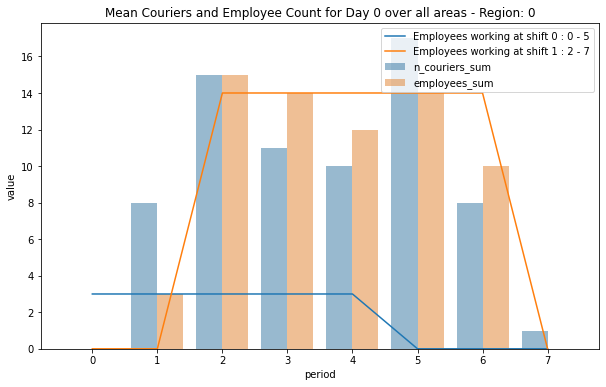

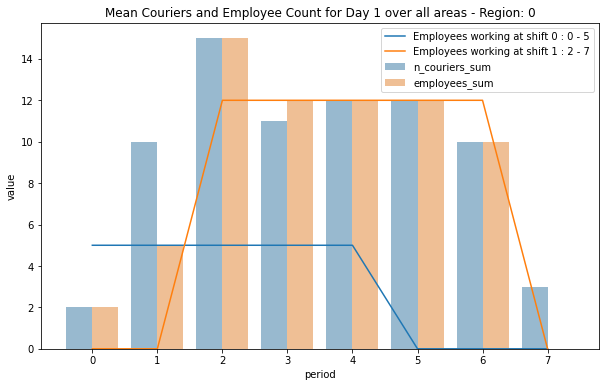

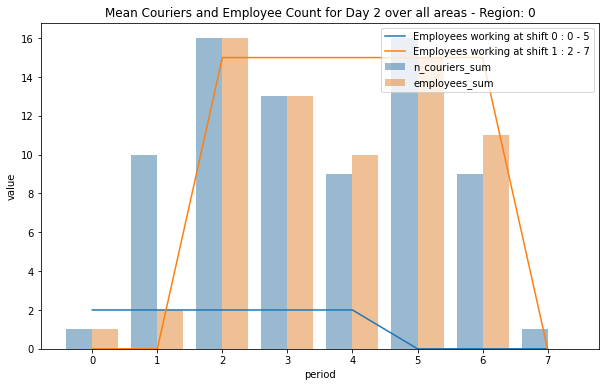

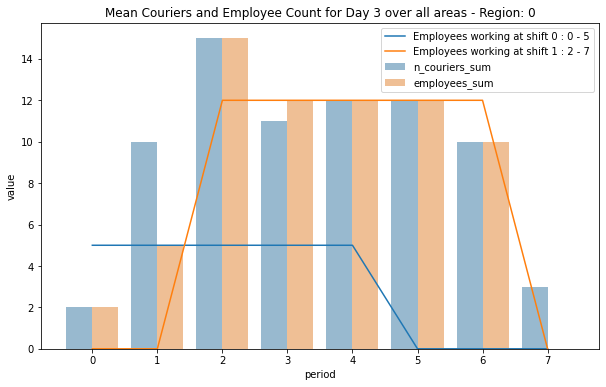

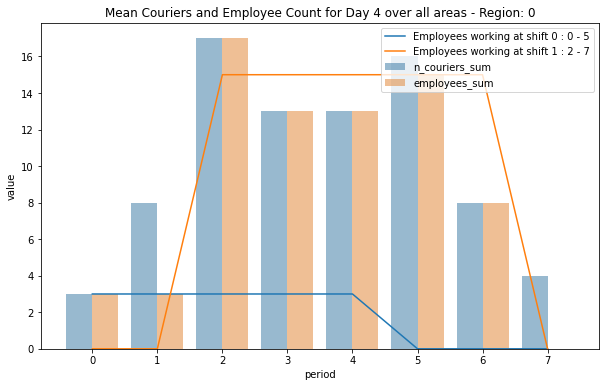

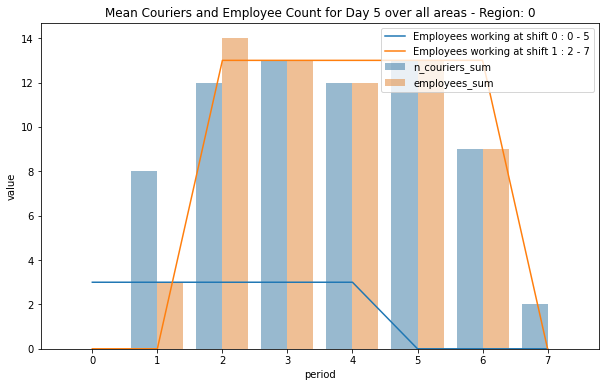

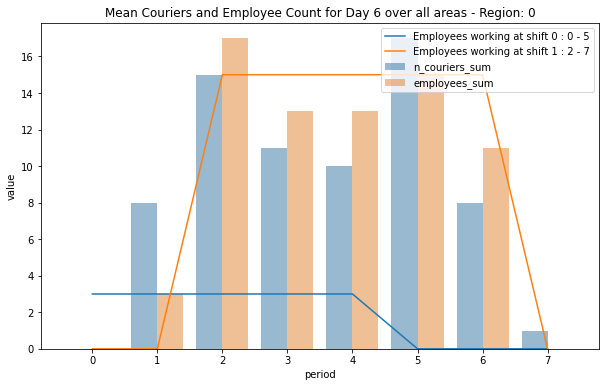

In [18]:
for d in s.D:
    _ = whole_solution_df.query(f'day == {d}').groupby('period').agg({'n_couriers': ['sum', 'mean', 'min', 'max'], 'employee_count': ['sum', 'mean', 'min', 'max']})
    _.columns = ['n_couriers_sum', 'n_couriers_mean', 'n_couriers_min', 'n_couriers_max',
                 'employees_sum', 'employees_mean', 'employees_min', 'employees_max']
    
    a = pd.melt(_.reset_index(), id_vars='period', value_vars=['n_couriers_sum', 'employees_sum'])
    plt.figure(figsize=(10, 6))

    sns.barplot(data=a, x='period', y='value', hue='variable', alpha=0.5)

    # SHIFTS
    for key, x in s.i.shifts_start[region].items():
        start = s.i.shifts_start[region][key]
        end = s.i.shifts_end[region][key]+1
        
        workers = day_employees_shifts_df.query(f'shift == {int(key)} & day == {d}')['value'].values[0]
        #periods_ = [x for x in range(8) if i in range(start, end)]

        sns.lineplot(x=[p for p in range(8)], y=[workers if i >= start and i < end else 0 for i in range(8)], label=f'Employees working at shift {key} : {start} - {end}')

    plt.title(f"Mean Couriers and Employee Count for Day {d} over all areas - Region: {region}")  # Adding title
    plt.legend(loc='upper right')  # Displaying legend
    
    plt.show()